# Problem Set 1 - K-Nearest Neighbor and NaiveBayes classifiers
## CSCI 5622 - Spring 2022


Student name: < Reid Glaze >
Only submit this notebook to canvas (no zip files).

For today's assignment, we will be implementing our own K-Nearest Neighbors classifier (KNNClassifier) algorithm and a Naive Bayes classifier. 

*But Professor Quigley, hasn't someone else already written KNN before?*

Yes, you are not the first to implement KNN, or basically any algorithm we'll work with in this class. But
1. I'll know that you know what's really going on
2. You'll know you can do it, because
    1. someday you might have to implement some machine learning algorithm from scratch - maybe for a new platform (do you need to run python on your SmartToaster just to get it to
learn how users like their toast?), maybe because you want to tweak the algorithm (there's always a better approach...),
    2. maybe because you're working on something important, and you need to control exactly what's on there
(should you really be running anaconda on your secret spy plane?).

That said - we're not going to implement *everything*. We'll start by importing a few helper functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors
import data
import tests
%matplotlib inline

*Wait a minute - didn't we just import Scikit-learn (sklearn)? The package with baked-in machine learning tools?*
 Yes - but it also has a ton of helper functions that we'll be using later.

You will be guided through the different questions and you'll be expected to complete the classes and the functions following the provided signatures.
 Sometimes at the end of a question we would provide a difficulty estimate using
the average scored by students who attempted the question (or a similar one) in previous assignments.

Remember to avoid adding positional arguments and make sure the returned values have the correct format (this applies to all assignments).
The alternative is that your solution might be rejected by the auto-grader (we won't be debugging your code).
We will provide some basic sanity checks. They're in no means exhaustive and passing them does not imply
your solution is 100% correct.


For example, you're required to complete the method `compute_something` of class A.
We provide examples of acceptable solutions.

First, let's also load a dataset to play with and start working to build out our own classifier.

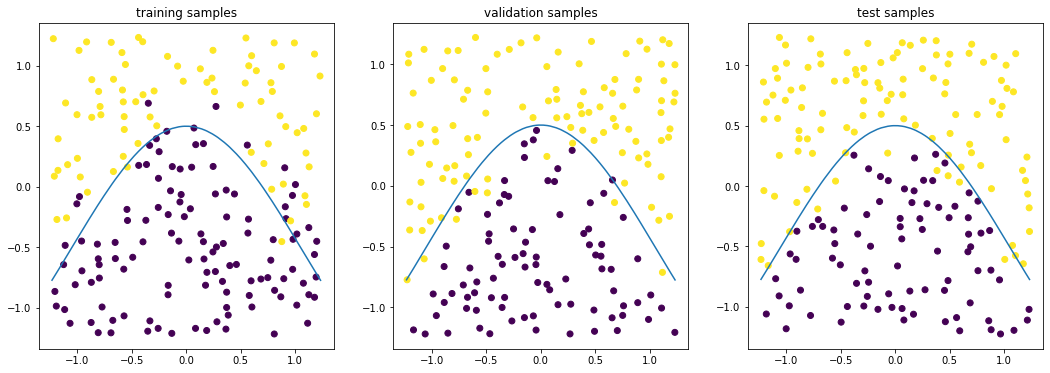

In [4]:
binary_data = data.BinaryData()
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
for i, name in enumerate(["training", "validation", "test"]):
    axs[i].plot(*binary_data.boundary())
    axs[i].set_title("%s samples" % name)
axs[0].scatter(binary_data.X_train[:, 0], binary_data.X_train[:, 1], c=binary_data.y_train)
axs[1].scatter(binary_data.X_valid[:, 0], binary_data.X_valid[:, 1], c=binary_data.y_valid)
axs[2].scatter(binary_data.X_test[:, 0], binary_data.X_test[:, 1], c=binary_data.y_test)
plt.show()

We have data! The `binary_data` instance has the following attributes:
   - a training set (`X_train, y_train`): to train the model and on which the prediction is based
   - a validation set (`X_valid, y_valid`): to select the best __hyper-parameters__ of the model
   - a test set (`X_test, y_test`): to evaluate the performance of the model on unseen data

### Problem 1: Complete our KNN Classifier - 30 Points

The KNNClassifier class we're implementing will have similar design to the K-Nearest Neighbors classifier class from *scikit-learn*:
- Initialize the classifier with corresponding parameters (number of neighbors k)
- A `fit` method that uses the training data
- A `predict` method that returns the predicted labels given data `X`

We've written out a lot of the structure for you for consistency across different parts of the assignment and so
you can focus on the "important" stuff that actually relates to the machine learning itself.

In [5]:
class KNNClassifier:

    def __init__(self, k=5):
        """
        Initialize our custom KNN classifier
        :param k: the number of nearest neighbors to consider for classification
        """
        self._k = k
        self._ball_tree = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None
        self.population_most_common = None

    def fit(self, X, y):
        """
        Fit the model using the provided data
        :param X: 2-D np.array of shape (number training samples, number of features)
        :param y: 1-D np.array of shape (number training samples,)
        :return: self
        """
        self._ball_tree = sklearn.neighbors.BallTree(X)  # See documentation of BallTree and how it's used
        self._y = y
        # Should be used to map the classes to {0,1,..C-1} if needed (C is the number of classes)
        # We can assume that the training data contains samples from all the possible classes
        classes = np.unique(y)
        self.label_to_index = dict(zip(classes, range(classes.shape[0])))
        self.index_to_label = dict(zip(range(classes.shape[0]), classes))

        label_values, label_counts = np.unique(y, return_counts=True)
        self.training_most_common = label_values[np.argmax(label_counts)]

        return self

    def majority_vote(self, indices_nearest_k, distances_nearest_k=None):
        """
        Given indices of the nearest k neighbors for each point, report the majority label of those points.
        :param indices_nearest_k: np.array containing the indices of training neighbors, of shape (M, k)
        :param distances_nearest_k: np.array containing the corresponding distances of training neighbors, of shape (M, k)
        :return: The majority label for each row of indices, shape (M,)
        """

        # Workspace 1.1
        # TODO: Determine majority for each row of indices_nearest_k
        # TODO: if there is a tie, set the label to the most common label in the training set
        #BEGIN 
        y = self._y
        k = self._k
        class_labels = []
        #print(indices_nearest_k.shape[0])
        #print(y.shape[0])
        for x in range(indices_nearest_k.shape[0]):
            index = indices_nearest_k[x]
            distances = distances_nearest_k[x]
            lab = []
            for z in range(index.shape[0]):
                lab.append(y[index[z]])
            label_values, label_counts = np.unique(lab, return_counts=True)
            lis = label_values[np.argmax(label_counts)]
            if (label_counts[0]) == k/2:
                ind = distances.argmax()
                index = np.delete(index, ind)
                distances = np.delete(distances, ind)
                lab = np.delete(lab, ind)
                label_values, label_counts = np.unique(lab, return_counts=True)
                lis = label_values[np.argmax(label_counts)]
            class_labels.append(lis)
        voted_labels = class_labels
        voted_labels = np.array(voted_labels)
        #END
        return voted_labels

    def predict(self, X):
        """
        Given new data points, classify them according to the training data provided in fit and number of neighbors k
        You should use BallTree to get the distances and indices of the nearest k neighbors
        :param X: feature vectors (num_points, num_features)
        :return: 1-D np.array of predicted classes of shape (num_points,)
        """
        # Workspace 1.2
        #BEGIN
        tree = self._ball_tree
        k = self._k
        distances_nearest_k, indices_nearest_k = tree.query(X, k)
        #END
        return self.majority_vote(indices_nearest_k, distances_nearest_k)

    def confusion_matrix(self, X, y):
        """
        Generate the confusion matrix for the given data
        :param X: an np.array of feature vectors of points, shape (N, n_features)
        :param y: the corresponding correct classes of our set, shape (N,)
        :return: a C*C np.array of counts, where C is the number of classes in our training data
        """
        # Workspace 1.3
        # The rows of the confusion matrix correspond to the counts from the true labels, the columns to the predictions'
        # TODO: Run classification for the test set X, compare to test answers y, and add counts to matrix
        #BEGIN 

        predicted = self.predict(X)

        classes = []
        for dict in self.label_to_index:
            #print(dict)
            classes.append(dict)
        classes = np.array(classes)

        confusion = np.zeros((classes.shape[0],classes.shape[0]))
        for ind, label in enumerate(y):
            for i in range(classes.shape[0]):
                if label == classes[i]:
                    # TP
                    for j in range(classes.shape[0]):
                        if predicted[ind] == classes[j]:
                             confusion[j,i] += 1
                
   

        conf = np.asarray(confusion)

        return conf
 
         
        #END

    def accuracy(self, X, y):
        """
        Return the accuracy of the classifier on the data (X_test, y_test)
        :param X: np.array of shape (m, number_features)
        :param y: np.array of shape (m,)
        :return: accuracy score [float in (0,1)]
        """
        # Workspace 1.4
        # TODO: Compute accuracy on X
        #BEGIN 
        predicted = self.predict(X)
        conf = self.confusion_matrix(X, y)
        #print(conf)
        #print(np.trace(conf))
        num = np.trace(conf)
        den = np.sum(conf)
        score = num/den
        # code here
        #END
        return score

In [6]:
# Test cell, uncomment to run the tests
knn = KNNClassifier()
knn.fit(binary_data.X_train, binary_data.y_train)
print("Predicted output")
print(knn.predict(binary_data.X_test))
print("Confusion matrix")
print(knn.confusion_matrix(binary_data.X_test, binary_data.y_test))
print("Accuracy score")
print(knn.accuracy(binary_data.X_test, binary_data.y_test))
print("--------------------------")
print("Tests")
tests.testKNN(KNNClassifier)

Predicted output
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0.]
Confusion matrix
[[82. 22.]
 [ 1. 87.]]
Accuracy score
0.8802083333333334
--------------------------
Tests
Question 1.1: [PASS]
Question 1.2: [PASS]
Question 1.3: [PASS]
Question 1.4: [PASS]


*But professor, this code isn't complete!*

1.1 [5 points] Complete the `majority_vote` function to determine the majority class of a series of neighbors.
If there is a tie, then you should remove the farthest element until the tie is broken. (Avg __4.6__)

1.2 [5 points] Complete the `predict` function to capture the predicted class of a new datapoint (Avg __4.9__)

 - HINT: Use the BallTree documentation to determine how to retrieve neighbors from the model (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)

1.3 [5 points] Complete the `confusion_matrix` function to reveal the results of classification (Avg __5__)

1.4 [5 points] Complete the `accuracy` function to get accuracy of the classifier based on a given test data (Avg __5__)

Below, we'll be using our KNNClassifier (sent in as "model") to show how we would predict any points in space given the input data.

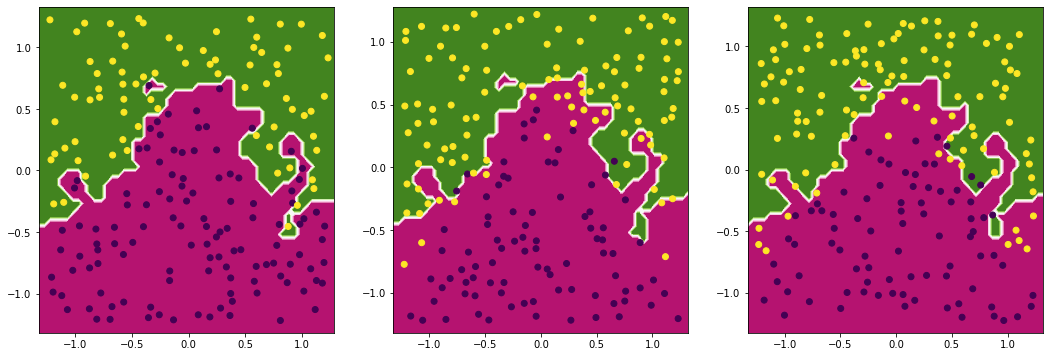

In [7]:
# This cell is to show the decision surface of the classifier
# You can change k to visualize KNN behavior
knn = KNNClassifier(2).fit(binary_data.X_train, binary_data.y_train)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
tests.show_decision_surface(knn, binary_data.X_train, binary_data.y_train, axs[0])
tests.show_decision_surface(knn, binary_data.X_valid, binary_data.y_valid, axs[1])
tests.show_decision_surface(knn, binary_data.X_test, binary_data.y_test, axs[2])
plt.show()

1.5 [5 points] For each k in the range [1,32], fit a KNNClassifier on the training set and plot the accuracies on training and validation
data versus k. What's the value of k that yields the best accuracy on the training set? on the validation set? Which one
 should we choose? (Avg __4.8__)

A k value of 0 yields the highest accuracy on training
A k value of 2 yields the highest accuracy on validation
-----------------------------
training accuracy
[1.         1.         0.96875    0.96875    0.91666667 0.91666667
 0.90625    0.90625    0.91145833 0.91145833 0.921875   0.921875
 0.93229167 0.93229167 0.92708333 0.92708333 0.921875   0.921875
 0.921875   0.921875   0.921875   0.921875   0.91666667 0.91666667
 0.93229167 0.93229167 0.92708333 0.92708333 0.921875   0.921875
 0.921875  ]
validation accuracy
[0.875      0.875      0.89583333 0.89583333 0.88541667 0.88541667
 0.86979167 0.86979167 0.86979167 0.86979167 0.88020833 0.88020833
 0.88541667 0.88541667 0.88541667 0.88541667 0.890625   0.890625
 0.88020833 0.88020833 0.86979167 0.86979167 0.875      0.875
 0.88020833 0.88020833 0.88541667 0.88541667 0.88541667 0.88541667
 0.890625  ]


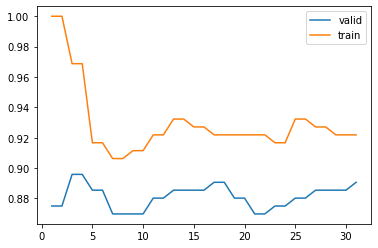

In [8]:
# Workspace 1.5.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k1 in ks:
    #BEGIN 
    knn = KNNClassifier(k=k1)
    knn.fit(binary_data.X_train, binary_data.y_train)
    accuracy_train = knn.accuracy(binary_data.X_train, binary_data.y_train)
    #print(accuracy_train)
    accuracy_valid = knn.accuracy(binary_data.X_valid, binary_data.y_valid)
    #print(accuracy_valid)
    #print("-------")
    accuracies_train.append(accuracy_train)
    accuracies_valid.append(accuracy_valid)
    #END
accuracies_train = np.asarray(accuracies_train)
accuracies_valid = np.asarray(accuracies_valid)
print("A k value of", accuracies_train.argmax(), "yields the highest accuracy on training")
print("A k value of", accuracies_valid.argmax(), "yields the highest accuracy on validation")
print("-----------------------------")
print("training accuracy")
print(accuracies_train)
print("validation accuracy")
print(accuracies_valid)
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()

### # Workspace 1.5.b
% Write up: best k for training and validation sets, and which one should we choose

% An optimal k value exists somewhere in between overfitting and underfitting. In this case, overfitting exists where the model matches the training data too closely. This results in a large gap in between the validation accuracy and the training accuracy. Overfitting exists at both, k=0 and k=2. Underfitting exists when the validation accuracy is too low. I would choose k = 5 for this model because the difference in between the accuracies is not large and the validation accuracy is still relatively high.

1.6 [5 points] Report the accuracy and the confusion matrix on the test set using the value of k chosen in 1.5 (Avg __5__)

In [9]:
# Workspace 1.6
# TODO: print the accuracy and confusion matrix on the test set using k from 1.5
#BEGIN 
knn = KNNClassifier(k=5)
knn.fit(binary_data.X_train, binary_data.y_train)
print("Accuracy for chosen k:")
print(knn.accuracy(binary_data.X_test, binary_data.y_test))
print("Confusion matrix for chosen k:")
print(knn.confusion_matrix(binary_data.X_test, binary_data.y_test))
#END

Accuracy for chosen k:
0.8802083333333334
Confusion matrix for chosen k:
[[82. 22.]
 [ 1. 87.]]


**Bonus (for the avid machine learner) (4 Points)**

1.7.a [1 point] A [__consistent classifier__](https://proceedings.neurips.cc/paper/1996/file/7bb060764a818184ebb1cc0d43d382aa-Paper.pdf)
on the training data is defined as a classifier that reaches 100% accuracy on the training set. For which values of k is KNNClassifier Consistent? (Avg __0.5__)

1.7.b [2 points] Edit your `KNNClassifier` so that it's consistent for all $k$ (we made sure that the change does not affect the sanity checks) (Avg __1__)

#### Write-up for the bonus
**Workspace 1.7.a**


When k=0 and k=1 the KNNClassifier is consistent. At these k values, the training accuracy reachoes 100%. This is not the case for k values greater than 1.


***
OK - now we've demonstrated that our KNN classifier works, let's think about our problem space! 

## Our Dataset - Identifying Digits from Images

It's a pretty common problem - just imagine working at the post office, and you're handed a hand-written check,
and you have to identify exactly what it says.
Did they pay 500 or 600 dollars? Is the letter going to 80309 (campus) or 30309 (Atlanta)?


### Problem 2: Improving KNN on Digits dataset - 20 Points

2.1 [4 points] `report` the number of examples different partitions of the digit dataset adn the number of pixels in the images (Avg __3.8__)

2.2 [6 points] complete the `evaluate` to perform the same evaluation we did in 1.5:
 - For k in range (1, 20):
    - initialize the classifier for k  and train in on the training set
    - Compute the accuracy on the validation set and save it
 - Choose k with the best accuracy on the validation set
 - Report the accuracy and the confusion matrix on the test set (use `display_confusion` for a cleaner output)


In [10]:
class Numbers:
    def __init__(self):
        self.data = data.DigitData() # it has the same structure as binary_data
        self.classifier = KNNClassifier()
    def report(self):
        """
        Report information about the dataset using the print() function
        """
        # Workspace 2.1
        #TODO: Create printouts for reporting the size of each set and the size of each datapoint
        #BEGIN 
        print("The training dataset has", self.data.X_train.shape[0], "samples and", self.data.X_train.shape[1], "pixels per sample")
        print("The validation dataset has", self.data.X_valid.shape[0], "samples and", self.data.X_valid.shape[1], "pixels per sample")
        print("The test dataset has", self.data.X_test.shape[0], "samples and", self.data.X_test.shape[1], "pixels per sample")
        #END

    def evaluate(self, classifier_class):
        """
        evaluates instances of the classifier class for different values of k and performs model selection
        :param classifier_class: Classifier class (either KNNClassifier or WeightedKNNClassifier)
        """

        # Workspace 2.2
        #BEGIN  
        ks = list(range(1, 20))
        accuracies_train = []
        accuracies_valid = []
        for k1 in ks:
            print("Testing k value:",k1, "of 20")
            knn = KNNClassifier(k=k1)
            knn.fit(self.data.X_train, self.data.y_train)
            accuracy_train = knn.accuracy(self.data.X_train, self.data.y_train)
            accuracy_valid = knn.accuracy(self.data.X_valid, self.data.y_valid)
            accuracies_train.append(accuracy_train)
            accuracies_valid.append(accuracy_valid)
        accuracies_train = np.asarray(accuracies_train)
        accuracies_valid = np.asarray(accuracies_valid)
        best_valid_k = accuracies_valid.argmax()
        knn = KNNClassifier(k=best_valid_k)
        knn.fit(self.data.X_train, self.data.y_train)
        confusion_matrix = knn.confusion_matrix(self.data.X_test, self.data.y_test)
        accuracy = knn.accuracy(self.data.X_test, self.data.y_test)
        ks = list(range(1, 20))
        accuracies_valid = []
        for k in ks:
            print(k, end="\r")
        print("best k:", best_valid_k)
        print("Accuracy on test set:", accuracy)
        self.display_confusion(confusion_matrix)
        #END

    def view_digit(self, index, partition):
        """
        Display a digit given its index and partition
        :param index: index of the digit image
        :param partition: partition from which the digit is retrieved, either "train", "valid" or "test"
        """
        %matplotlib inline
        image = {"train": self.data.X_train, "valid": self.data.X_valid, "test": self.data.X_test}[partition][index]
        label = {"train": self.data.y_train, "valid": self.data.y_valid, "test": self.data.y_test}[partition][index]
        image = image.reshape(28, 28)
        plt.figure()
        plt.matshow(image)
        plt.title("Digit %i" % label)
        plt.show()

    @staticmethod
    def display_confusion(c_matrix):
        """
        Displays the confusion matrix using matshow
        :param c_matrix: square confusion matrix, shape (num_classes, num_classes)
        """
        _, ax = plt.subplots()
        ax.matshow(c_matrix, cmap=plt.cm.Blues)
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[0]):
                ax.text(i, j, str(c_matrix[j, i]), va='center', ha='center')
        plt.show()


The training dataset has 1000 samples and 784 pixels per sample
The validation dataset has 500 samples and 784 pixels per sample
The test dataset has 500 samples and 784 pixels per sample
Testing k value: 1 of 20
Testing k value: 2 of 20
Testing k value: 3 of 20
Testing k value: 4 of 20
Testing k value: 5 of 20
Testing k value: 6 of 20
Testing k value: 7 of 20
Testing k value: 8 of 20
Testing k value: 9 of 20
Testing k value: 10 of 20
Testing k value: 11 of 20
Testing k value: 12 of 20
Testing k value: 13 of 20
Testing k value: 14 of 20
Testing k value: 15 of 20
Testing k value: 16 of 20
Testing k value: 17 of 20
Testing k value: 18 of 20
Testing k value: 19 of 20
best k: 3
Accuracy on test set: 0.88


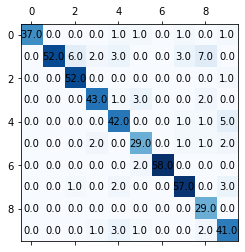

In [11]:
# Run evaluate of Numbers and shopws the confusion matrix
numbers = Numbers()
numbers.report()
numbers.evaluate(KNNClassifier)

*Wow, I can't believe we just created a KNN Classifier for multiple classes - but can't we make it better?*

Yes, we saw above that our classifier didn't work perfectly. Let's explore try to understand why.


2.3 [10 points] Determine which classes are most often confused (from our confusion matrix above),
 inspect some examples of these digits (using the `view_digit` function in our Numbers class),
 and write a brief (4 - 5 sentences) description of why you think these particular numbers may be misclassified. (Avg __9.1__)

An actual 8 was misclassified as a predicted 1 seven times.


<Figure size 432x288 with 0 Axes>

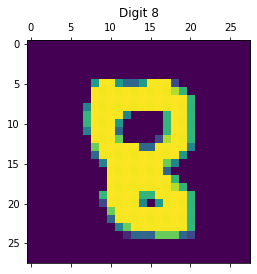

<Figure size 432x288 with 0 Axes>

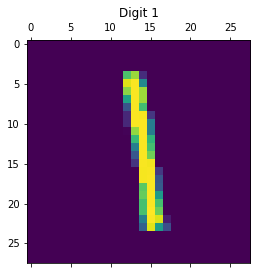

-----------------------------------------
An actual 2 was misclassified as a predicted 1 six times.


<Figure size 432x288 with 0 Axes>

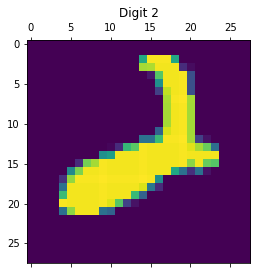

<Figure size 432x288 with 0 Axes>

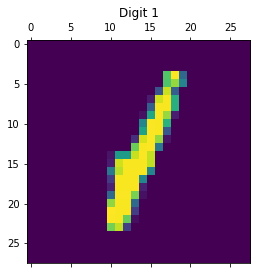

-----------------------------------------
An actual 9 was misclassified as a predicted 4 five times. An actual 4 was misclassified as a predicted 9 three times.


<Figure size 432x288 with 0 Axes>

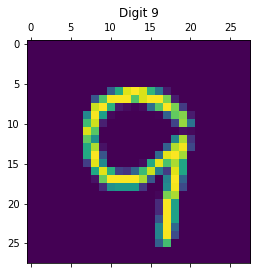

<Figure size 432x288 with 0 Axes>

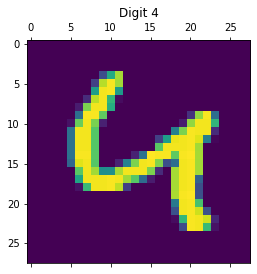

-----------------------------------------


In [12]:
# Workspace 2.3.a
#TODO: Print out problem class images
#BEGIN
numbers = Numbers()
print("An actual 8 was misclassified as a predicted 1 seven times.")
numbers.view_digit(15, "test")
numbers.view_digit(6, "test")
print("-----------------------------------------")
print("An actual 2 was misclassified as a predicted 1 six times.")
numbers.view_digit(55, "test")
numbers.view_digit(58, "test")
print("-----------------------------------------")
print("An actual 9 was misclassified as a predicted 4 five times. An actual 4 was misclassified as a predicted 9 three times.")
numbers.view_digit(44, "test")
numbers.view_digit(19, "test")
print("-----------------------------------------")
#END

**Workspace 2.3.b**

TODO: Write description of mis-classification

An actual 8 was misclassified as a 1 seven times. This is likely due to 8 pictures being made up of multiple long lines that can be mistaken for 1s. These long lines can be drawn diagonally across the 8 or on either side of the 8. An actual 2 was misclassified as a predicted 1 six times. This is likely due to the bottom part of the 2 being drawn carelessly or replicating the base of a 1. An actual 9 was misclassified as a predicted 4 five times and an actual 4 was misclassified as a predicted 9 three times. This is likely due to the fact that 4s can look similar to 9s, especially when the circle of a 9 is not fully enclosed. This could also be due to the corners on a 4 not being drawn very sharply.

### Problem 3 : Improving KNN on MNIST using WeightedKNN (25 pts)
Complete the `WeightedKNNClassifier` class to perform the weighted KNN classification.
The Weighted KNN classifier assigns weights to the nearest-neighbor training examples proportional to
 the inverse-distance from the training example to the query point.

Classification is performed by summing the weights associated with each class and predicting the class with the highest weighted-majority vote.
 Mathematically, we might describe the weighted-vote for a class $c$ as

\begin{align}
\textrm{Weighted-Vote}(c)(x) = \sum_{i \in {\cal N}_K(x)} I(y_i \in c) \times \frac{1}{\|{\bf x}_i - {\bf x}\|}
\end{align}

where ${\cal N}_K(x)$ is the set of the nearest $k$ neighbors to $x$.

3.1 [10 points] Complete `weighted_vote`: it's certainly possible that a query point could be distance $0$ away from some training example.
 If this happens your implementation should handle it and return the appropriate class label.(Avg __7.8__)

3.2 [5 points] Complete `predict`. (Avg __4.9__)


In [13]:
class WeightedKNNClassifier(KNNClassifier):

    def weighted_vote(self, indices_nearest_k, distances_nearest_k):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param indices_nearest_k: The indices of the K nearest neighbors in self.X_train
        :param distances_nearest_k: Corresponding distances from query point to K nearest neighbors.
        """
        # Workspace 3.1
        #BEGIN 
        y = self._y
        class_labels = []
        classes = []
        for dict in self.label_to_index:
            classes.append(dict)
        classes = np.array(classes)
        for x in range(indices_nearest_k.shape[0]):
            index = indices_nearest_k[x]
            distances = distances_nearest_k[x]
            lab = []
            for z in range(index.shape[0]):
                lab.append(y[index[z]])
            lab = np.array(lab)
            if distances.all() > -1:
                with np.errstate(divide='ignore', invalid='ignore'):
                    weights = np.true_divide(1,distances)
                weighted_vote = np.zeros(classes.shape[0])
                for i in range(classes.shape[0]):
                    for j in range(lab.shape[0]):
                        if classes[i] == lab[j]:
                            weighted_vote[i] = weighted_vote[i] + weights[j]
                ind = np.argmax(weighted_vote)
                c = classes[ind]
                class_labels.append(c)
        weighted_vote = class_labels
        weighted_vote = np.array(weighted_vote)
        #END 
        return weighted_vote

    def predict(self, X):
        """
        Given an np.array of query points, return y_hat, an np.array of predictions
        :param X: an (m x p) dimension np.array of points to predict labels for
        """

        # Workspace 3.2
        ##BEGIN 
        tree = self._ball_tree
        k = self._k
        distances_nearest_k, indices_nearest_k = tree.query(X, k)
        labels = self.weighted_vote(indices_nearest_k, distances_nearest_k)
        #END
        return labels

In [14]:
# Test cell, uncomment to run the tests
knn = WeightedKNNClassifier(3).fit(binary_data.X_train, binary_data.y_train)
print("Predicted output")
print(knn.predict(binary_data.X_test))
print("------------------------")
print("Tests")
tests.testWeightedKNN(WeightedKNNClassifier)

Predicted output
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0.]
------------------------
Tests
Question 3.1: [PASS]
Question 3.2: [PASS]


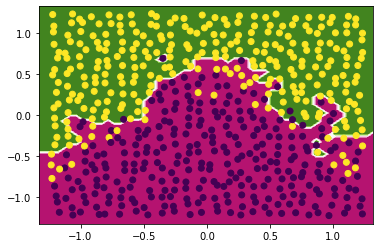

In [15]:
# Example on how to use the show_decision_surface
knn = WeightedKNNClassifier(3).fit(binary_data.X_train, binary_data.y_train)
knn.predict(binary_data.X_test)
tests.show_decision_surface(knn, binary_data.X, binary_data.y)

3.3 [5 points] Evaluate `WeightedKNNClassifier` on the binary data, similar to 1.5 digits data using `Numbers` class and compare it to `KNNClassifier` (Avg __4.6__)

A k value of 0 yields the highest accuracy on training
A k value of 3 yields the highest accuracy on validation
-----------------------------
training accuracy
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
validation accuracy
[0.875      0.875      0.88541667 0.89583333 0.890625   0.88541667
 0.86979167 0.86979167 0.86979167 0.86979167 0.875      0.875
 0.88020833 0.88020833 0.88020833 0.88541667 0.88020833 0.88541667
 0.88020833 0.88541667 0.88541667 0.88541667 0.88020833 0.88541667
 0.88541667 0.890625   0.88020833 0.890625   0.88541667 0.890625
 0.890625  ]


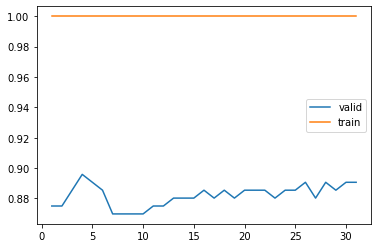

Accuracy for chosen k value of 3:
0.890625


In [16]:
# Workspace 3.3.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k1 in ks:
    #BEGIN 
    knn = WeightedKNNClassifier(k=k1)
    knn.fit(binary_data.X_train, binary_data.y_train)
    accuracy_train = knn.accuracy(binary_data.X_train, binary_data.y_train)
    accuracy_valid = knn.accuracy(binary_data.X_valid, binary_data.y_valid)
    accuracies_train.append(accuracy_train)
    accuracies_valid.append(accuracy_valid)
    #END
accuracies_train = np.asarray(accuracies_train)
accuracies_valid = np.asarray(accuracies_valid)
print("A k value of", accuracies_train.argmax(), "yields the highest accuracy on training")
print("A k value of", accuracies_valid.argmax(), "yields the highest accuracy on validation")
print("-----------------------------")
print("training accuracy")
print(accuracies_train)
print("validation accuracy")
print(accuracies_valid)
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()
knn = WeightedKNNClassifier(k=3)
knn.fit(binary_data.X_train, binary_data.y_train)
print("Accuracy for chosen k value of 3:")
print(knn.accuracy(binary_data.X_test, binary_data.y_test))

### # Workspace 3.3.b
% Write up: Which classifier does better on the binary data

% These classifiers were very similar in terms of accuracy. When I used a k value of 3 on the WeightedKNNClassifier, I got about 0.89. When I used a k value of 5 on the KNNClassifier, i got about 0.88. By these metrics, I would use the WeightedKNNClassifier because I got a higher accuracy score. However, I took overfitting into account with the KNNClassifier, but not with the WeightedKNNClassifier. WeightedKNNClassifier is a consistent classifier, so it is hard to find an optimal point in between overftting and underfitting. In summary, an argument could be made for either classifier being better, but I am choosing WeightedKNNClassifier based on my accuracy score results from chosen optimal k values.


3.4 [5 points] Compare `WeightedKNNClassifier` to `KNNClassifier` on the digits' data using `Numbers` class.

The training dataset has 1000 samples and 784 pixels per sample
The validation dataset has 500 samples and 784 pixels per sample
The test dataset has 500 samples and 784 pixels per sample
Testing k value: 1 of 20
Testing k value: 2 of 20
Testing k value: 3 of 20
Testing k value: 4 of 20
Testing k value: 5 of 20
Testing k value: 6 of 20
Testing k value: 7 of 20
Testing k value: 8 of 20
Testing k value: 9 of 20
Testing k value: 10 of 20
Testing k value: 11 of 20
Testing k value: 12 of 20
Testing k value: 13 of 20
Testing k value: 14 of 20
Testing k value: 15 of 20
Testing k value: 16 of 20
Testing k value: 17 of 20
Testing k value: 18 of 20
Testing k value: 19 of 20
best k: 3
Accuracy on test set: 0.88


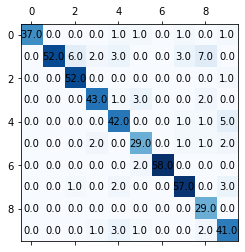

In [17]:
#Workspace 3.4.a
#BEGIN 
numbers = Numbers()
numbers.report()
numbers.evaluate(WeightedKNNClassifier)
#END

#### 3.4.b write-up
% Both of the classifiers are remarkably similar when a k value of 3 is used. They both result in an accuracy score of 0.88 Furthermore, the misclassifications are extremely similar. Seven 8s are misclassified as 1. Six 2s are misclassified as 1. Five 9s are misclassified as 4 and three 4s are misclassified as 9s.

#### Bonus
3.5 [2 points] Is `WeightedKNNClassifier` a consistent classifier? why? (Avg __1.1__)


#### 3.5 write-up
% WeightedKNNClassifier is a consistent classifier. This is because the training accuracy is 100% for every value of k. This happens because of data points that are 0 distance away from the training data. This results in a weight value of infinite being calculated into the weighted votes. 

### Problem 4 - Naive Bayes [25 points]
***
Consider the problem of predicting whether a person has a college degree based on age, salary, and Colorado residency.
The dataset looks like the following.

|Age|Salary|Colorado Resident| Has Siblings | College degree|
|:------:|:-----------:| :----------:| :----------:|--:|
| 37 | 44,000 | Yes | No  | Yes|
| 61 | 52,000 | Yes | No  | No |
| 23 | 44,000 | No  | No  | Yes|
| 39 | 38,000 | No  | Yes | Yes|
| 48 | 49,000 | No  | No  | Yes|
| 57 | 92,000 | No  | Yes | No |
| 38 | 41,000 | No  | Yes | Yes|
| 27 | 35,000 | Yes | No  | No |
| 23 | 26,000 | Yes | No  | No |
| 38 | 45,000 | No  | No  | No |
| 32 | 50,000 | No  | No  | Yes|
| 25 | 52,000 | Yes | No  | Yes|


In [18]:
features = np.array([
    [37, 44000, 1, 0],
    [61, 52000, 1, 0],
    [23, 44000, 0, 0],
    [39, 38000, 0, 1],
    [48, 49000, 0, 0],
    [57, 92000, 0, 1],
    [38, 41000, 0, 1],
    [27, 35000, 1, 0],
    [23, 26000, 1, 0],
    [38, 45000, 0, 0],
    [32, 50000, 0, 0],
    [25, 52000, 1, 0]
])
labels = np.array([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1])

4.1 [3 points] Complete `threshold_features` to convert age and salary features to binary ones using the threshold arguments. (Avg __2.9__)

In [19]:
def threshold_features(features, age_threshold, salary_threshold):
    """
    Transform afe and salary to binary
    :param features: data array of shape (m, n_features) where features[:,0] for age, features[:,1} for salary
    :param age_threshold: used to "binarize" the data, 1 if age > age_threshold and 0 otherwise
    :param salary_threshold: used to "binarize" the data, 1 if salary > salary_threshold and 0 otherwise
    :return: binary features matrix
    """
    binary_features = features * 1  #This row just creates a "hard copy" of the X array so we can manipulate it as needed

    # Workspace 4.1
    #BEGIN 
    col_1 = binary_features[:,0]
    col_2 = binary_features[:,1]
    col_1_binary = np.where(col_1 > age_threshold, 1, 0)
    col_2_binary = np.where(col_2 > salary_threshold, 1, 0)    
    binary_features[0,0] = 0
    for i in range(col_1_binary.shape[0]):
        binary_features[i,0] = col_1_binary[i]
        binary_features[i,1] = col_2_binary[i]
    #END

    return binary_features

In [20]:
# Test cell, uncomment to run the tests
print(threshold_features(features, 40, 40000))
tests.test_threshold(threshold_features)

[[0 1 1 0]
 [1 1 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [1 1 0 0]
 [1 1 0 1]
 [0 1 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 1 0]]
Question 4.1: [PASS]


4.2 [2 points] If we were to use only one binary feature (age >40, salary > 40000, colorado resident, has siblings),
then what's the highest accuracy we could achieve? Which feature should we use?

**Workspace 4.2**

% Looking at the label values, [1 0 1 1 1 0 1 0 0 0 1 1], I compared the accuracies of each of the 4 columns shown above. I got: age = 4/12, salary = 8/12, resident = 4/12, siblings = 4/12.
Salary would result in the highest accuracy of 8/12 or 0.67

## How to implement NaiveBayes
As seen during the class, given a row $(x_1, x_2, x_3)$, the naive Bayes classifier should assign the label $y$ that
maximizes:

\begin{align}
\log [p(y) \prod_i p(x_i | y)] = \log p(y) + \sum_{i} \log p(x_i | y)
\end{align}

$p(y)$ and $p(x_i | y)$ are computed using the training set (during `fit` call).

For this, we need two attributes to store
$\log p(y)$ and $\log p(x_i | y)$ for different features $i$.

Let's assume we're working with binary classes $\{0, 1\}$ and all features have discrete supports.
Then we will store `classes_log_probability` as an array of shape `(2,)` that contains:
\begin{bmatrix}
\log p(y=0),\log p(y=1)
\end{bmatrix}.

If feature $i$ has $2$ possible values $\{0, 1\}$, then $\log p(x_i | y)$ would be stored as a $ 2 \times 2$ matrix:
\begin{align}
A_i = \begin{bmatrix}
\log p(x_i=0 | y=0) & \log p(x_i=1| y=0)\\
\log p(x_i=0 | y=1) & \log p(x_i=1 | y=1)
\end{bmatrix}
\end{align}

`features_log_likelihood` should then store such matrix for each feature.

We have defined $p(x_i | y)$ as :
\begin{align}
p(x_i | y) = \frac{N_{y,x_i}}{N_y}
\end{align}
where $N_{y,i}$ is the number of rows where $y$ and $x_i$ occur together, and $N_y = \sum_i N_{y,x_i}$.

4.3 [2 points] Complete the method `compute_classes` and store the log prior in `classes_log_probability` (Avg __2__)

4.4 [5 points] Complete the method `compute_features` by storing the matrices $A_i$ in `self.features_log_likelihood` (Avg __4.3__)

4.5 [5 points] Complete the method `join_log_likelihood` that computes the likelihood quantities
 $[\sum_{i} \log p(x_i | y=0), \sum_{i} \log p(x_i | y=1)]$ for each observation

4.6 [3 points] Complete the `predict` method

In [28]:
class NaiveBayes(object):
    """
    NaiveBayes classifier for binary features and binary labels
    """

    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.classes_counts = None
        self.classes_log_probability = np.empty((2,))
        self.features_log_likelihood = []  # list of arrays where element i store log p(X[:,i], y)

    def compute_classes(self, y):
        """
        Computes the log prior of binary classes and stores the result in self.classes_log_probability
        :param y: binary labels array, shape (m,)
        """
        # Workspace 4.3
        #BEGIN
        ones = np.count_nonzero(y)
        total = y.shape[0]
        zeros = y.shape[0]-ones
        zeros = zeros/total
        ones = ones/total    
        zero_log = np.log(zeros)
        ones_log = np.log(ones)
        self.classes_log_probability = [zero_log, ones_log]
        #END

    def compute_features(self, X, y):
        """
        Computes the log likelihood matrices for different features and stores them in self.features_log_likelihood
        :param X: data matrix with binary features, shape (n_samples, n_features)
        :param y: binary labels array, shape (n_samples,)
        """
        # Workspace 4.4
        #BEGIN 
        y_1_indices = []
        y_0_indices = []
        for i in range(y.shape[0]):
            if y[i]!=0:
                y_1_indices.append(i)
            else:
                y_0_indices.append(i)
        y_0_indices = np.array(y_0_indices)
        y_1_indices = np.array(y_1_indices)
        y_1 = np.empty((0,4), int)
        y_0 = np.empty((0,4), int)
        for j in range(y_1_indices.shape[0]):
            y_1_add = X[y_1_indices[j],:]
            y_1 = np.append(y_1, np.array([y_1_add]), axis=0)
        for k in range(y_0_indices.shape[0]):
            y_0_add = X[y_0_indices[k],:]
            y_0 = np.append(y_0, np.array([y_0_add]), axis=0)
        list_1 = []
        for a in range(X.shape[1]):
            ones = np.count_nonzero(y_0[:,a])
            total = y_0.shape[0]
            zeros = y_0.shape[0]-ones
            zeros = zeros/total
            ones = ones/total
            zero_log = np.log(zeros)
            ones_log = np.log(ones)
            cond_0_0 = zero_log
            cond_1_0 = ones_log
            ones = np.count_nonzero(y_1[:,a])
            total = y_1.shape[0]
            zeros = y_1.shape[0]-ones
            zeros = zeros/total
            ones = ones/total
            zero_log = np.log(zeros)
            ones_log = np.log(ones)
            cond_0_1 = zero_log
            cond_1_1 = ones_log
            matrix = np.array([[cond_0_0, cond_1_0],[cond_0_1, cond_1_1]])
            list_1.append(matrix)
        self.features_log_likelihood = list_1

        #END

    def fit(self, X, y):
        """
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :param y: corresponding binary labels of shape (n_samples,) [values 0 or 1]
        :return: Classifier
        """
        self.compute_classes(y)
        self.compute_features(X, y)
        return self

    def joint_log_likelihood(self, X):
        """
        Computes the joint log likelihood
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :return: joint log likelihood array jll of shape (n_samples, 2), where jll[i] = [log p(X[i]|y=0),log p(X[i]|y=1)]
        """
        # Workspace 4.5
        #BEGIN
        matrix_list = self.features_log_likelihood
        mat_1 = matrix_list[0]
        mat_2 = matrix_list[1]
        mat_3 = matrix_list[2]
        mat_4 = matrix_list[3]
        joint_log_likelihood = np.zeros((X.shape[0], 2))
        for i in range(X.shape[0]):
            if X[i,0] == 0:
                sum_1 = mat_1[0,0]
            if X[i,0] == 1:
                sum_1 = mat_1[0,1]
            if X[i,1] == 0:
                sum_2 = mat_2[0,0]
            if X[i,1] == 1:
                sum_2 = mat_2[0,1]
            if X[i,2] == 0:
                sum_3 = mat_3[0,0]
            if X[i,2] == 1:
                sum_3 = mat_3[0,1]
            if X[i,3] == 0:
                sum_4 = mat_4[0,0]
            if X[i,3] == 1:
                sum_4 = mat_4[0,1]
            summ = sum_1 + sum_2 + sum_3 + sum_4
            joint_log_likelihood[i, 0] = summ
        for j in range(X.shape[0]):
            if X[j,0] == 0:
                sum_1 = mat_1[1,0]
            if X[j,0] == 1:
                sum_1 = mat_1[1,1]
            if X[j,1] == 0:
                sum_2 = mat_2[1,0]
            if X[j,1] == 1:
                sum_2 = mat_2[1,1]
            if X[j,2] == 0:
                sum_3 = mat_3[1,0]
            if X[j,2] == 1:
                sum_3 = mat_3[1,1]
            if X[j,3] == 0:
                sum_4 = mat_4[1,0]
            if X[j,3] == 1:
                sum_4 = mat_4[1,1]
            summ = sum_1 + sum_2 + sum_3 + sum_4
            joint_log_likelihood[j, 1] = summ
        #END
        return joint_log_likelihood

    def predict(self, X):
        """
        :param X:
        :return:
        """

        # Workspace 4.6
        # TODO: Find the corresponding labels using Naive bayes logic
        #BEGIN 
        output = []
        matrix_list = self.features_log_likelihood
        classes = self.classes_log_probability
        mat_1 = matrix_list[0]
        mat_2 = matrix_list[1]
        mat_3 = matrix_list[2]
        mat_4 = matrix_list[3]
        mult = np.zeros((X.shape[0], 2))  
        for i in range(X.shape[0]):
            if X[i,0] == 0:
                mult_1 = mat_1[0,0]
            if X[i,0] == 1:
                mult_1 = mat_1[0,1]
            if X[i,1] == 0:
                mult_2 = mat_2[0,0]
            if X[i,1] == 1:
                mult_2 = mat_2[0,1]
            if X[i,2] == 0:
                mult_3 = mat_3[0,0]
            if X[i,2] == 1:
                mult_3 = mat_3[0,1]
            if X[i,3] == 0:
                mult_4 = mat_4[0,0]
            if X[i,3] == 1:
                mult_4 = mat_4[0,1]
            m = mult_1 * mult_2 * mult_3 * mult_4 * classes[0]
            mult[i, 0] = m
        for j in range(X.shape[0]):
            if X[j,0] == 0:
                mult_1 = mat_1[1,0]
            if X[j,0] == 1:
                mult_1 = mat_1[1,1]
            if X[j,1] == 0:
                mult_2 = mat_2[1,0]
            if X[j,1] == 1:
                mult_2 = mat_2[1,1]
            if X[j,2] == 0:
                mult_3 = mat_3[1,0]
            if X[j,2] == 1:
                mult_3 = mat_3[1,1]
            if X[j,3] == 0:
                mult_4 = mat_4[1,0]
            if X[j,3] == 1:
                mult_4 = mat_4[1,1]
            m = mult_1 * mult_2 * mult_3 * mult_4 * classes[1]
            mult[j, 1] = m
        for i in range(mult.shape[0]):
            if mult[i, 0] > mult[i, 1]:
                output.append(0)
            else:
                output.append(1)
        y_hat = np.array(output)
        #END
        return y_hat

In [29]:
# Test cell, uncomment to run the tests
NB = NaiveBayes()
NB.fit(threshold_features(features, 40, 40000), labels)
print("Joint log likelihood")
print(NB.joint_log_likelihood(threshold_features(features, 40, 40000)))
print("Predicted labels")
print(NB.predict(threshold_features(features, 40, 40000)))
print("-------------------")
print("Tests")
tests.test_NB(NaiveBayes)

Joint log likelihood
[[-1.75562042 -1.89753656]
 [-2.16108553 -3.68929603]
 [-2.16108553 -0.98124583]
 [-3.952845   -3.68929603]
 [-2.56655064 -2.7730053 ]
 [-3.952845   -3.68929603]
 [-3.54737989 -1.89753656]
 [-2.16108553 -3.68929603]
 [-2.16108553 -3.68929603]
 [-2.16108553 -0.98124583]
 [-2.16108553 -0.98124583]
 [-1.75562042 -1.89753656]]
Predicted labels
[1 0 1 1 1 1 1 0 0 1 1 1]
-------------------
Tests
Question 4.3: [PASS]
Question 4.4: [PASS]
Question 4.5: [PASS]
Question 4.6: [PASS]


4.7 [5 points] Using age 40 and salary 40,000 as thresholds, transform the features and evaluate (accuracy) the NaiveBayes classifier
on the training data. Does it outperform our baseline (of using one feature)? (Avg __4.5__)

In [23]:

# Workspace 4.5
#TODO: Transform features to binary features, fit the classifier, report the accuracy
#BEGIN 
NB = NaiveBayes()
NB.fit(threshold_features(features, 40, 40000), labels)
print("Predicted labels")
print(NB.predict(threshold_features(features, 40, 40000)))
print("Actual labels")
print(labels)
#END

Predicted labels
[1 0 1 1 1 1 1 0 0 1 1 1]
Actual labels
[1 0 1 1 1 0 1 0 0 0 1 1]


4.7) Yes, Naive Bayes classification outperforms using one feature to determine the output. In this example, the classifier correctly classifies 10/12 outputs and has a 0.83 accuracy score. This outperforms our baseline, which correctly classified 8/12 outputs and had a 0.67 accuracy score.

**Bonus**

4.8 [2 points] Use the attribute `alpha` of the NaiveBayes to convert it to smoothed NaiveBayes presented during the class.
`alpha`defaults to 0, so editing the class should not affect NaiveBayes tests (Avg __1.8__)

In [25]:
NB = NaiveBayes(alpha=1)
NB.fit(threshold_features(features, 40, 40000), labels)
print("Predicted labels")
print(NB.predict(threshold_features(features, 40, 40000)))

Predicted labels
[1 0 1 1 1 1 1 0 0 1 1 1]
